In [1]:
import sys, os
sys.path.append(os.path.join('..', '..'))

import torch
from torch.utils.data import DataLoader
from datasets import Dataset
import random
import copy
import itertools
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from data_generators.causal_model import CausalModel
from sklearn.metrics import classification_report
from transformers import get_linear_schedule_with_warmup
from models.mlp.modelings_mlp import MLPConfig
from models.mlp.modelings_alignable_mlp import create_mlp_classifier
from models.configuration_alignable_model import AlignableRepresentationConfig, AlignableConfig
from models.interventions import VanillaIntervention, RotatedSpaceIntervention, LowRankRotatedSpaceIntervention
from models.alignable_base import AlignableModel

In [2]:
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# Helper Functions

In [3]:
def plot_vectors(X,Y,Z):
    
    _, ax = plt.subplots()

    ax.quiver(0, 0, X[0], X[1], angles='xy', scale_units='xy', scale=1, color='r', label='X')
    ax.quiver(0, 0, Y[0], Y[1], angles='xy', scale_units='xy', scale=1, color='g', label='Y')
    ax.quiver(0, 0, Z[0], Z[1], angles='xy', scale_units='xy', scale=1, color='b', label='Z')

    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.legend()

    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.show()

def intervention_id(intervention):
    if "P" in intervention and "Q" in intervention:
        return 2
    if "P" in intervention:
        return 0
    if "Q" in intervention:
        return 1

def compute_metrics(eval_preds, eval_labels):
    total_count = 0
    correct_count = 0
    for eval_pred, eval_label in zip(eval_preds, eval_labels):
        total_count += 1
        correct_count += (eval_pred== eval_label)
    accuracy = float(correct_count)/float(total_count)
    return {"accuracy" : accuracy}

def compute_loss(outputs, labels):
    CE = torch.nn.CrossEntropyLoss()
    return CE(outputs, labels)

def batched_random_sampler(data, batch_size):
    batch_indices = [ _ for _ in range(int(len(data)/batch_size))]
    random.shuffle(batch_indices)
    for b_i in batch_indices:
        for i in range(b_i*batch_size, (b_i + 1)*batch_size):
            yield i


# Z is between X and Y

The task is inspired by the example in the [Wu, Geiger, Potts, Goodman (2023)](https://arxiv.org/abs/2305.08809), called by the authors the _price tagging game_. A number _Z_ is given and the algorithm should output if it is between _X_ and _Y_. For example given `X=4.5`, `Y=9.56` and `Z=12.49`, the algorithm should output `False`.

We define an algorithm which solves this task by a left-right boundary method. It first checks the left boundary, if _X_ is less or equal to _Z_, then it checks the right boundary, if _Z_ is less or equal to _Y_.

In [4]:
def randvec(n=50, lower=-1, upper=1):
    return np.array([round(random.uniform(lower, upper), 2) for i in range(n)])

embedding_dim = 2
number_of_entities = 20

variables =  ["X", "Y", "Z", "P", "Q", "O"]

reps = [randvec(embedding_dim, lower=-1, upper=1) for _ in range(number_of_entities)]
values = {variable:reps for variable in ["X","Y","Z"]}
values["P"] = [True, False]
values["Q"] = [True, False]
values["O"] = [True, False]

parents = {"X":[],"Y":[], "Z":[], 
           "P":["X", "Z"], "Q":["Y", "Z"], 
           "O":["P", "Q"]}

def FILLER():
    return reps[0]

check_lower = lambda x, y: np.linalg.norm(x) <= np.linalg.norm(y) # check if the magnitude is lower

functions = {"X":FILLER, "Y":FILLER, "Z":FILLER, 
             "P": lambda x,y: check_lower(x,y), 
             "Q":lambda x,y: check_lower(y,x), 
             "O": lambda x,y: x and y}

pos = {"X":(1,0.1), "Y":(2,0.2), "Z":(2.8,0), 
        "P":(1,2), "Q":(2,2), 
        "O":(1.5,3)}

equiv_classes = {}

left_right_boundary_model = CausalModel(variables, values, parents, functions, pos = pos)

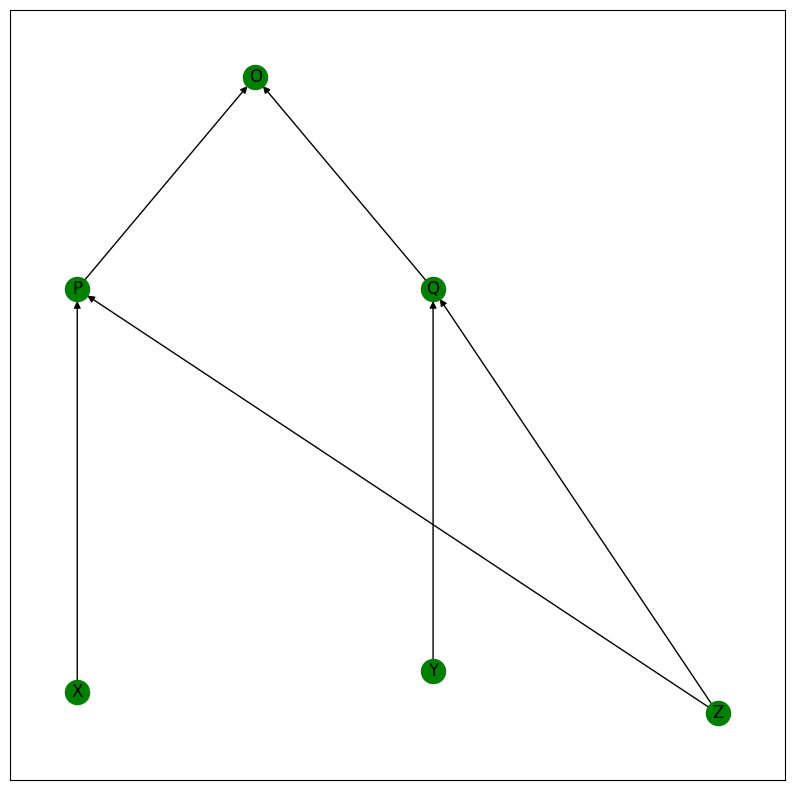

Timesteps: {'X': 0, 'Y': 0, 'Z': 0, 'P': 1, 'Q': 1, 'O': 3}


In [5]:
left_right_boundary_model.print_structure()
print("Timesteps:", left_right_boundary_model.timesteps)

## No interventions

No intervention:
 defaultdict(None, {'X': array([ 0.78, -0.83]), 'Y': array([0.61, 0.4 ]), 'Z': array([-0.56,  0.01]), 'P': False, 'Q': True, 'O': False}) 



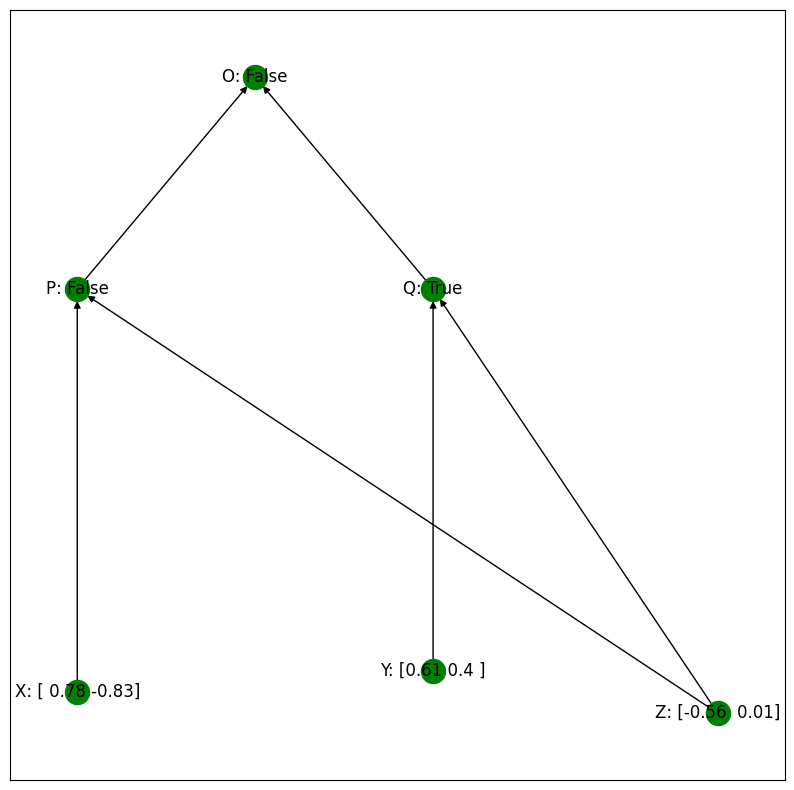

In [6]:
setting = left_right_boundary_model.run_forward({"X":reps[3], "Y":reps[10], "Z":reps[5]})
print("No intervention:\n", setting, "\n")
left_right_boundary_model.print_setting(setting)

## With an intervention

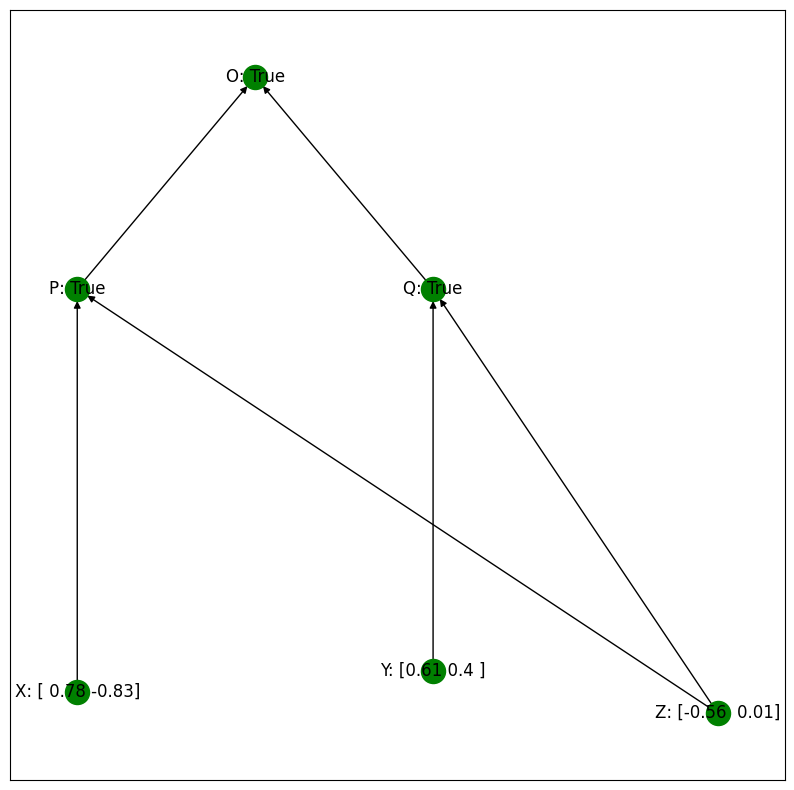

In [7]:
left_right_boundary_model.print_setting(left_right_boundary_model.run_forward({"X":reps[3], "Y":reps[10], "Z":reps[5], "P":True}))

To notice that even though _X_ is not less or equal to _Z_, the intervention changed the value of the intermediate variable, _P_ from _False_ to _True_. Now the algorithm outputs _True_.

## Interchange Intervention

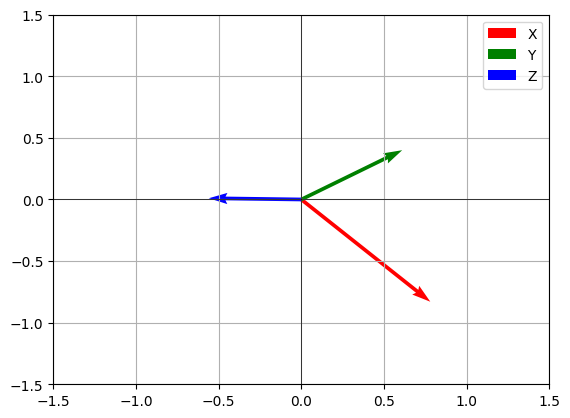

In [8]:
plot_vectors(X=reps[3], Y=reps[10], Z=reps[5])

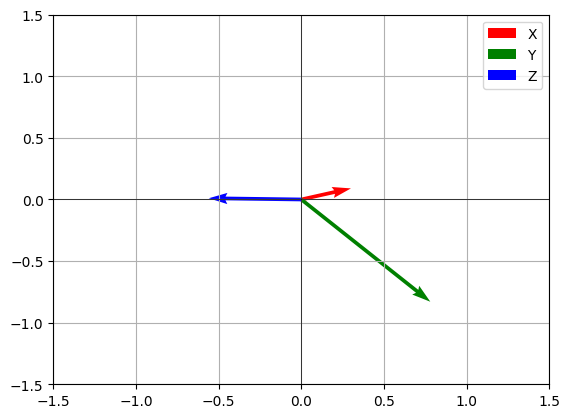

In [9]:
plot_vectors(X=reps[7], Y=reps[3], Z=reps[5])

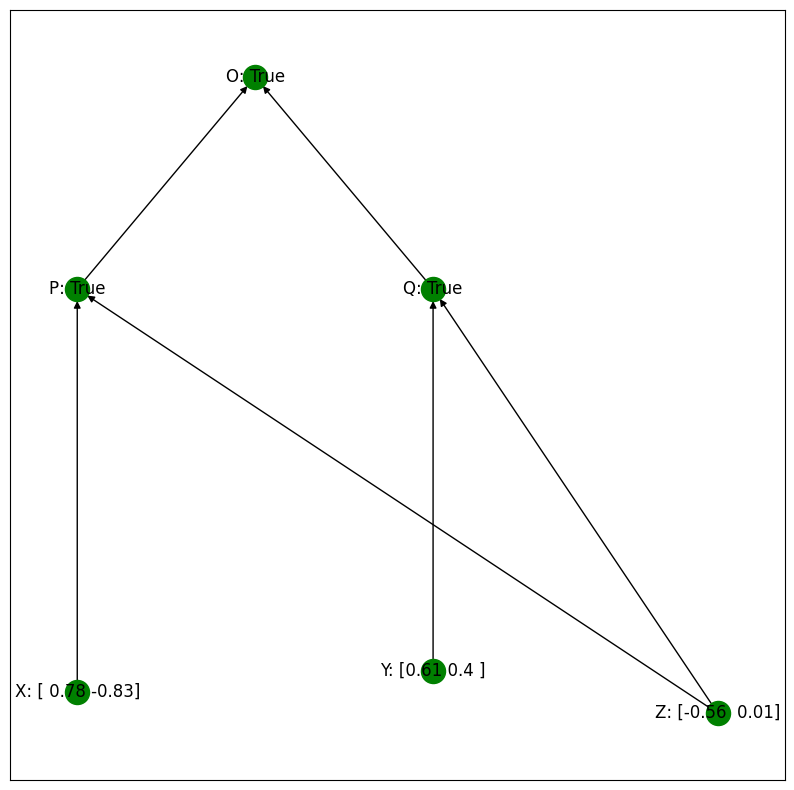

In [10]:
base = {"X":reps[3], "Y":reps[10], "Z":reps[5]}
source = {"X":reps[7], "Y":reps[3], "Z":reps[5]}
setting = left_right_boundary_model.run_interchange(base, {"P":source})
left_right_boundary_model.print_setting(setting)

# Train an MLP for knowing if a number has a specific boundary

In [11]:
embedding_dim = 4

# check how to improve the sampling
def input_sampler():
    A = randvec(4)
    B = randvec(4)
    C = randvec(4)
    x = random.randint(1,3)
    if x == 1:
        return {"X":A, "Y":B, "Z":C}
    elif x == 2:
        return {"X":A, "Y":A, "Z":B}
    elif x == 3:
        return {"X":B, "Y":B, "Z":B}

In [12]:
n_examples = 102400
batch_size = 1024

X, y = left_right_boundary_model.generate_factual_dataset(n_examples,input_sampler)

X = X.unsqueeze(1)

In [13]:
config = MLPConfig(h_dim=embedding_dim*3,
          activation_function = "relu",
          n_layer = 3,
          n_labels = 2,
          pdrop = 0.0
         )
config, tokenizer, trained = create_mlp_classifier(config)
trained.train()

loaded model


MLPForClassification(
  (mlp): MLPModel(
    (dropout): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-2): 3 x MLPBlock(
        (ff1): Linear(in_features=12, out_features=12, bias=True)
        (act): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (score): Linear(in_features=12, out_features=2, bias=True)
)

In [14]:
train_ds = Dataset.from_dict({
    "labels":[torch.FloatTensor([0,1]) if i == 1 else torch.FloatTensor([1,0]) for i in y],
    "inputs_embeds":X})

In [15]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
                output_dir="test_trainer", 
                evaluation_strategy="epoch",
                learning_rate=0.001,
                num_train_epochs=6,
                per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=batch_size
                )

trainer = Trainer(
    model=trained,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=train_ds,
    compute_metrics=lambda x: {"accuracy":classification_report(x[0].argmax(1),x[1].argmax(1), output_dict=True)["accuracy"]},
)

In [16]:
_ = trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pislarmara589 (master-thesis-mara). Use `wandb login --relogin` to force relogin


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.648550,0.609248
2,No log,0.511469,0.789326
3,No log,0.361874,0.915967
4,No log,0.316037,0.916270
5,0.466300,0.300700,0.915098
6,0.466300,0.296367,0.916543


/home/mara/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mara/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mara/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
variables = ["X", "Y", "Z", "P", "Q", "O"]

number_of_test_entities = 100

reps = [randvec(embedding_dim)  for _ in range(number_of_test_entities)]
values = {variable:reps for variable in ["X", "Y", "Z"]}
values["P"] = [True, False]
values["Q"] = [True, False]
values["O"] = [True, False]

parents = {"X":[],"Y":[], "Z":[], 
           "P":["X", "Z"], "Q":["Y", "Z"], 
           "O":["P", "Q"]}

def FILLER():
    return reps[0]

check_lower = lambda x, y: np.linalg.norm(x) <= np.linalg.norm(y) # check if the magnitude is lower

functions = {"X":FILLER, "Y":FILLER, "Z":FILLER, 
             "P": lambda x,y: check_lower(x,y), 
             "Q":lambda x,y: check_lower(y,x), 
             "O": lambda x,y: x and y}

pos = {"X":(1,0.1), "Y":(2,0.2), "Z":(2.8,0), 
        "P":(1,2), "Q":(2,2), 
        "O":(1.5,3)}

test_left_right_boundary_model = CausalModel(variables, values, parents, functions, pos = pos)

In [18]:
X_test, y_test = test_left_right_boundary_model.generate_factual_dataset(10000,input_sampler)
print("Test Results")

test_ds = Dataset.from_dict({
    "labels":[torch.FloatTensor([0,1]) if i == 1 else torch.FloatTensor([1,0]) for i in y_test],
    "inputs_embeds":X_test})

test_preds = trainer.predict(test_ds)

print(classification_report(y_test, test_preds[0].argmax(1)))

Test Results


              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93      6117
         1.0       0.92      0.87      0.89      3883

    accuracy                           0.92     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.92      0.92     10000



# Apply DAS for every layer

In [19]:
def train_alignable_model(alignable, train_dataset, optimizer, embedding_dim, batch_size = 640, epochs = 6):
    total_step = 0
    gradient_accumulation_steps = 1
    alignable.model.train() # train enables drop-off but no grads
    print("intervention trainable parameters: ", alignable.count_parameters())
    train_iterator = trange(
        0, int(epochs), desc="Epoch"
    )

    for epoch in train_iterator:
        epoch_iterator = tqdm(
            DataLoader(train_dataset,
                    batch_size=batch_size,
                    sampler=batched_random_sampler(train_dataset, batch_size)),
            desc=f"Epoch: {epoch}", 
            position=0, 
            leave=True
        )
        for batch in epoch_iterator:
            batch["input_ids"] = batch["input_ids"].unsqueeze(1)    
            batch["source_input_ids"] = batch["source_input_ids"].unsqueeze(2) 
            batch_size = batch["input_ids"].shape[0]
            if batch["intervention_id"][0] == 2:
                _, counterfactual_outputs = alignable(
                        {"inputs_embeds":batch["input_ids"]},
                        [{"inputs_embeds":batch["source_input_ids"][:, 0]}, 
                        {"inputs_embeds":batch["source_input_ids"][:,1]}],
                        {"sources->base": ([[[0]]*batch_size, [[0]]*batch_size], [[[0]]*batch_size, [[0]]*batch_size])},
                    subspaces=[[[_ for _ in range(0,embedding_dim*2)]]*batch_size, 
                            [[_ for _ in range(embedding_dim*2, embedding_dim*3)]]*batch_size]
                    )
            elif batch["intervention_id"][0] == 0:
                _, counterfactual_outputs = alignable(
                        {"inputs_embeds":batch["input_ids"]},
                        [{"inputs_embeds":batch["source_input_ids"][:,0]}, None],
                        {"sources->base": ([[[0]]*batch_size, None], [[[0]]*batch_size, None])},
                        subspaces=[[[_ for _ in range(0,embedding_dim*2)]]*batch_size, 
                                None]
                    )
            elif batch["intervention_id"][0] == 1:
                _, counterfactual_outputs = alignable(
                        {"inputs_embeds":batch["input_ids"]},
                        [None, {"inputs_embeds":batch["source_input_ids"][:,0]}],
                        {"sources->base": ([None, [[0]]*batch_size], [None, [[0]]*batch_size])},
                        subspaces=[None, 
                                [[_ for _ in range(embedding_dim*2, embedding_dim*3)]]*batch_size]
                    )
            eval_metrics=compute_metrics(counterfactual_outputs[0].argmax(1), batch['labels'].squeeze())

            # loss and backprop
            loss = compute_loss(
                counterfactual_outputs[0], batch["labels"].squeeze().to(torch.long)
            )

            epoch_iterator.set_postfix({'loss': loss, 'acc': eval_metrics["accuracy"]})
            
            if gradient_accumulation_steps > 1:
                loss = loss / gradient_accumulation_steps
            loss.backward()
            if total_step % gradient_accumulation_steps == 0:
                    optimizer.step()
                    alignable.set_zero_grad()
            total_step += 1

In [20]:
def test_alignable_model(alignable, test_dataset, embedding_dim, batch_size = 640):
    eval_labels = []
    eval_preds = []
    with torch.no_grad():
        epoch_iterator = tqdm(DataLoader(test_dataset, batch_size), desc=f"Test")
        for step, batch in enumerate(epoch_iterator):
            for k, v in batch.items():
                if v is not None and isinstance(v, torch.Tensor):
                    batch[k] = v.to("cuda")
            batch["input_ids"] = batch["input_ids"].unsqueeze(1)    
            batch["source_input_ids"] = batch["source_input_ids"].unsqueeze(2)    
            if batch["intervention_id"][0] == 2:
                _, counterfactual_outputs = alignable(
                        {"inputs_embeds":batch["input_ids"]},
                        [{"inputs_embeds":batch["source_input_ids"][:, 0]}, 
                        {"inputs_embeds":batch["source_input_ids"][:,1]}],
                        {"sources->base": ([[[0]]*batch_size, [[0]]*batch_size], [[[0]]*batch_size, [[0]]*batch_size])},
                        subspaces=[[[_ for _ in range(0,embedding_dim*2)]]*batch_size, 
                            [[_ for _ in range(embedding_dim*2, embedding_dim*3)]]*batch_size]
                    )
            elif batch["intervention_id"][0] == 0:
                _, counterfactual_outputs = alignable(
                        {"inputs_embeds":batch["input_ids"]},
                        [{"inputs_embeds":batch["source_input_ids"][:,0]}, None],
                        {"sources->base": ([[[0]]*batch_size, None], [[[0]]*batch_size, None])},
                        subspaces=[[[_ for _ in range(0,embedding_dim*2)]]*batch_size, 
                                None]
                    )
            elif batch["intervention_id"][0] == 1:
                _, counterfactual_outputs = alignable(
                        {"inputs_embeds":batch["input_ids"]},
                        [None, {"inputs_embeds":batch["source_input_ids"][:,0]}],
                        {"sources->base": ([None, [[0]]*batch_size], [None, [[0]]*batch_size])},
                        subspaces=[None, 
                                [[_ for _ in range(embedding_dim*2, embedding_dim*3)]]*batch_size]
                    )
            eval_labels += [batch['labels']]
            eval_preds += [torch.argmax(counterfactual_outputs[0],dim=1)]

    report = classification_report(torch.cat(eval_labels).cpu(), torch.cat(eval_preds).cpu(), output_dict=True)
    print(report)
    return report

In [21]:
def save_results(layer, report):
    with open(f'report_{layer}.json', 'w') as json_file:
        json.dump(report, json_file)

In [22]:
def DAS_per_layer(model, train_dataset, test_dataset, layer = 0, batch_size = 640, lr = 0.001, embedding_dim = 4):
    alignable_config = AlignableConfig(
        alignable_model_type=type(model),
        alignable_representations=[
            AlignableRepresentationConfig(
                layer,             # layer
                "block_output", # intervention type
                "pos",    # intervention unit is now aligne with tokens
                1,                 # max number of unit
                subspace_partition=None,      # binary partition with equal sizes
                intervention_link_key=0        
            ),
            AlignableRepresentationConfig(
                layer,             # layer
                "block_output", # intervention type
                "pos",    # intervention unit is now aligne with tokens
                1,                 # max number of unit
                subspace_partition=None,# binary partition with equal sizes,
                intervention_link_key=0
            ),
        ],
        alignable_interventions_type= RotatedSpaceIntervention,
    )

    alignable = AlignableModel(alignable_config, model, use_fast=True)
    alignable.set_device("cuda")
    alignable.disable_model_gradients()

    optimizer_params = []
    for k, v in alignable.interventions.items():
        optimizer_params += [{'params': v[0].rotate_layer.parameters()}]
        break
    optimizer = torch.optim.Adam(
        optimizer_params,
        lr=lr
    )
    
    train_alignable_model(alignable, train_dataset, optimizer, embedding_dim, batch_size=batch_size)
    report = test_alignable_model(alignable, test_dataset, embedding_dim, batch_size=batch_size)
    save_results(layer, report)

In [23]:
n_examples = 128000
batch_size = 640

train_dataset = left_right_boundary_model.generate_counterfactual_dataset(n_examples,
                                                        intervention_id,
                                                        batch_size,
                                                        device = "cuda:0",
                                                        sampler=input_sampler)

test_dataset = test_left_right_boundary_model.generate_counterfactual_dataset(n_examples,
                                                    intervention_id,
                                                    batch_size,
                                                    device = "cuda:0",
                                                    sampler=input_sampler)

for layer in range(config.n_layer):
    DAS_per_layer(trained, train_dataset, test_dataset, layer, batch_size)


In case multiple location tags are passed only the first one will be considered


intervention trainable parameters:  144


Epoch: 0: 200it [00:15, 12.64it/s, loss=tensor(1.1352, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.65] 
Epoch: 1: 200it [00:15, 12.80it/s, loss=tensor(1.1819, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.636]
Epoch: 2: 200it [00:18, 10.87it/s, loss=tensor(1.0836, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.658]
Epoch: 3: 200it [00:18, 10.63it/s, loss=tensor(1.1324, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.653]
Epoch: 4: 200it [00:16, 12.21it/s, loss=tensor(1.0813, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.652]
Epoch: 5: 200it [00:16, 12.10it/s, loss=tensor(1.0880, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.637]
Test: 100%|██████████| 200/200 [00:04<00:00, 43.31it/s]

In case multiple location tags are passed only the first one will be considered


{'0.0': {'precision': 0.6484918053695555, 'recall': 0.8617066350309296, 'f1-score': 0.74004803143876, 'support': 70806}, '1.0': {'precision': 0.7112696821371705, 'recall': 0.4217575270133231, 'f1-score': 0.529525398428239, 'support': 57194}, 'accuracy': 0.665125, 'macro avg': {'precision': 0.6798807437533629, 'recall': 0.6417320810221263, 'f1-score': 0.6347867149334995, 'support': 128000}, 'weighted avg': {'precision': 0.67654272633711, 'recall': 0.665125, 'f1-score': 0.6459805980606057, 'support': 128000}}
intervention trainable parameters:  144


Epoch: 0: 200it [00:16, 12.33it/s, loss=tensor(0.9958, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.656]
Epoch: 1: 200it [00:15, 12.54it/s, loss=tensor(1.0062, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.673]
Epoch: 2: 200it [00:16, 11.94it/s, loss=tensor(0.9948, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.639]
Epoch: 3: 200it [00:15, 12.91it/s, loss=tensor(0.9687, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.636]
Epoch: 4: 200it [00:15, 12.93it/s, loss=tensor(1.0159, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.65] 
Epoch: 5: 200it [00:15, 12.73it/s, loss=tensor(0.9889, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.642]
Test: 100%|██████████| 200/200 [00:03<00:00, 50.89it/s]

In case multiple location tags are passed only the first one will be considered


{'0.0': {'precision': 0.6498896531036403, 'recall': 0.8567353049176624, 'f1-score': 0.7391134829544069, 'support': 70806}, '1.0': {'precision': 0.7073114432454267, 'recall': 0.4286113928034409, 'f1-score': 0.5337717197230327, 'support': 57194}, 'accuracy': 0.6654375, 'macro avg': {'precision': 0.6786005481745335, 'recall': 0.6426733488605516, 'f1-score': 0.6364426013387199, 'support': 128000}, 'weighted avg': {'precision': 0.6755473239268383, 'recall': 0.6654375, 'f1-score': 0.6473610079055382, 'support': 128000}}
intervention trainable parameters:  144


Epoch: 0: 200it [00:16, 12.39it/s, loss=tensor(1.1250, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.628]
Epoch: 1: 200it [00:14, 13.51it/s, loss=tensor(1.0548, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.667]
Epoch: 2: 200it [00:17, 11.45it/s, loss=tensor(1.0372, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.653]
Epoch: 3: 200it [00:16, 12.02it/s, loss=tensor(0.9329, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.697]
Epoch: 4: 200it [00:14, 13.46it/s, loss=tensor(0.9905, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.647]
Epoch: 5: 200it [00:15, 13.22it/s, loss=tensor(0.9063, device='cuda:0', grad_fn=<NllLossBackward0>), acc=0.684]
Test: 100%|██████████| 200/200 [00:03<00:00, 64.37it/s]


{'0.0': {'precision': 0.6475734951003267, 'recall': 0.862370420585826, 'f1-score': 0.7396939999273159, 'support': 70806}, '1.0': {'precision': 0.7108994897353744, 'recall': 0.41897751512396403, 'f1-score': 0.5272271237156498, 'support': 57194}, 'accuracy': 0.66425, 'macro avg': {'precision': 0.6792364924178506, 'recall': 0.640673967854895, 'f1-score': 0.6334605618214828, 'support': 128000}, 'weighted avg': {'precision': 0.6758693305468652, 'recall': 0.66425, 'f1-score': 0.64475782400505, 'support': 128000}}


# Visualize results

In [24]:
report_dicts = []

for layer in range(config.n_layer):
    file_path = f'/home/mara/workspace/thesis/align-transformers/results/left_right_boundary_model/no_subspace_partition/report_{layer}.json'
    with open(file_path, 'r') as json_file:
        report_dict = json.load(json_file)
        report_dicts.append(report_dict)

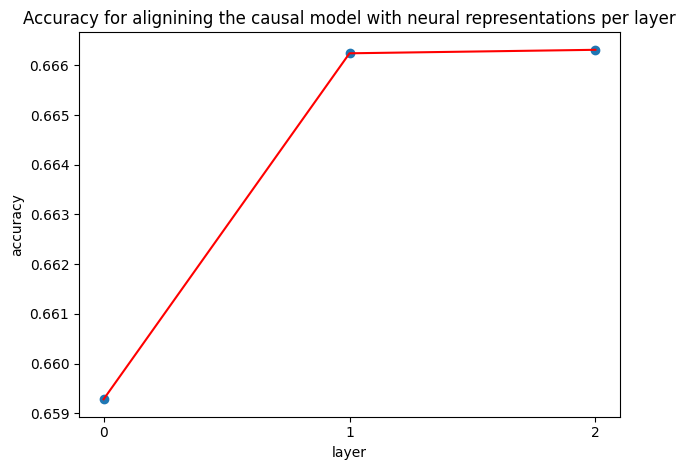

In [25]:
values = []
for layer, report_dict in enumerate(report_dicts, start=1):
    values.append(report_dict['accuracy'])

plt.scatter(range(config.n_layer), values)
plt.plot(range(config.n_layer), values,color='r')
plt.xticks(range(int(min(plt.xticks()[0])), int(max(plt.xticks()[0])) + 1))
plt.xlabel('layer')
plt.ylabel('accuracy')
plt.title('Accuracy for alignining the causal model with neural representations per layer')

plt.tight_layout()
plt.show()

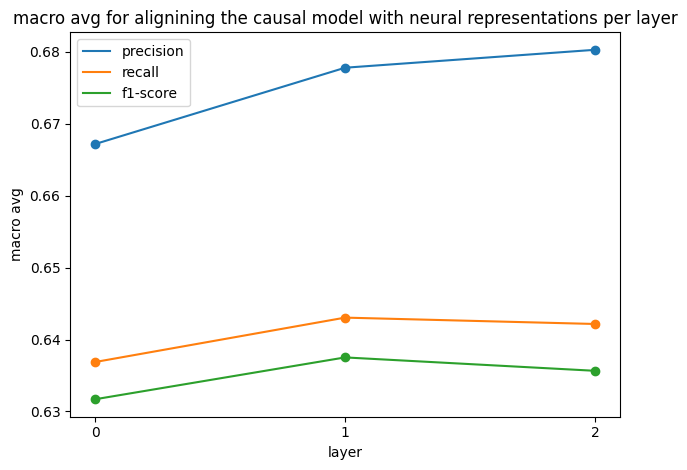

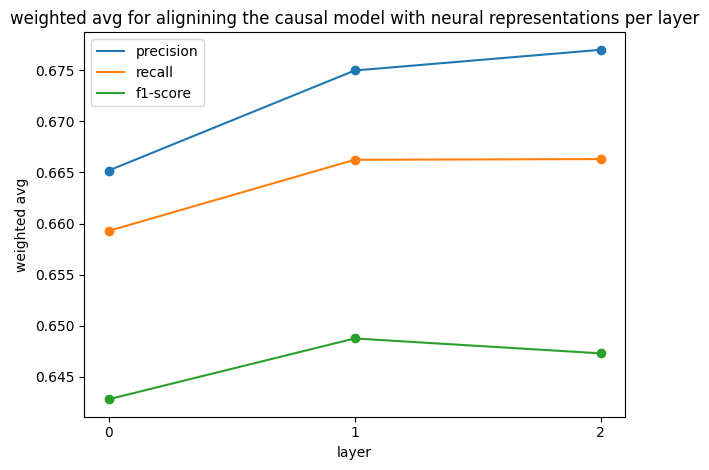

: 

In [26]:
averages = ['macro avg', 'weighted avg']
metrics = ['precision', 'recall', 'f1-score']

for average in averages:
    for metric in metrics:
        values = []
        for layer, report_dict in enumerate(report_dicts, start=1):
            values.append(report_dict[average][metric])
        plt.scatter(range(config.n_layer), values)
        plt.plot(range(config.n_layer), values, label=metric)
    
    plt.xticks(range(int(min(plt.xticks()[0])), int(max(plt.xticks()[0])) + 1))
    plt.xlabel('layer')
    plt.ylabel(average)
    plt.title(f'{average} for alignining the causal model with neural representations per layer')
    plt.tight_layout()
    plt.legend()
    plt.show()